## Basic model / scratch pad

- Simplify data and attempt to overfit with a single class
- Make jaccard cost function to assess model performance in a way that matches submission ranking
- Use datagenerator to randomly change images and increase the training size

In [1]:
%reset
import timeit
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.optimizers import SGD,Adagrad,Adadelta,Adam
from keras.layers import Activation, Dense, Reshape, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Deconvolution2D, UpSampling2D, ZeroPadding2D,Cropping2D#, Unpooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import train_test_split
import pickle
from keras.backend import set_image_dim_ordering
set_image_dim_ordering('th')

from shapely.ops import cascaded_union
from shapely.geometry import MultiPolygon,asShape, Polygon
from shapely.geometry.polygon import Polygon,asPolygon
#from rasterio.features import shapes,rasterize
from rasterio import features
from shapely.affinity import scale # scales the wkt values using the description in the tutorial

from shapely import speedups
speedups.available
speedups.enable()

from matplotlib import pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


Using TensorFlow backend.


In [2]:
# Load the components of the pushbullet API

from pushbullet import Pushbullet
with open('../pushbullet.api','r') as f:
    api = f.readline().strip()   
pb = Pushbullet(api)
phone = pb.devices[0]

In [3]:
# Run this cell after anything you want to be notified about!
def push(title='Done!',text='Whatever it was, it\'s done'):
    phone.push_note(title,text)

In [4]:
# Import the training data
# To do: train_test_split the data first
load_whitened = False

with open('./data/x_resized_array.pickle','rb') as f:
    x = pickle.load(f)
    
if load_whitened:
    with open('./data/x_whitened_resized_array.pickle','rb') as f:
        x_whitened = pickle.load(f)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j,:,:] *= 1/x[i,j,:,:].max()
        
with open('./data/y_resized_raster.pickle','rb') as f:
    y = pickle.load(f)

# Just use a single class: roads
#y = y[:,4,:,:]
#y = y[:,np.newaxis,:,:]

# y = y.reshape(y.shape[0],-1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

In [8]:
# Make training data with only one class
# Remember to change the last layer in the network to ahve a single output
# Also change the range(10) in the polygonize_data() list comprehension to range(1)
# Finally, obviously feed the correct training data to the model.fit() method

y_one = y[:,3,:,:]
y_one = y_one[:,np.newaxis,:,:]
x_one_train, x_one_test, y_one_train, y_one_test = train_test_split(x,y_one,test_size=0.25, random_state=42)

In [5]:
'''
See https://github.com/fchollet/keras/issues/1287

This seems to be working well as an autoencoder
'''

lr = 0.0001
decay = 1e-3
n_conv = 3
n_filters = 32
batch_size = 1

leaky = LeakyReLU()
sgd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
adagrad = Adagrad(lr=0.001, epsilon=1e-08, decay=0.0)
adadelta = Adadelta()
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
act = 'relu'
init = 'he_normal'

model = Sequential()

#############################
### Convolution layer 1   ###
#############################

model.add(ZeroPadding2D(padding=(28,28),input_shape=(1,136,136)))
model.add(Convolution2D(8,n_conv,n_conv,border_mode='same',init=init))
model.add(Activation(act))

model.add(Convolution2D(8,n_conv,n_conv,border_mode='same',init=init))
model.add(Activation(act))

model.add(MaxPooling2D(pool_size=(2, 2),border_mode='same'))

#############################
### Convolution layer 2   ###
#############################

model.add(Convolution2D(16,n_conv,n_conv,border_mode='same',init=init))
model.add(Activation(act))

model.add(Convolution2D(16,n_conv,n_conv,border_mode='same',init=init))
model.add(Activation(act))

model.add(MaxPooling2D(pool_size=(2, 2),border_mode='same'))

#############################
##  Deconvolution layer 1  ##
#############################

model.add(Convolution2D(8,n_conv,n_conv,border_mode='same',init=init))
model.add(Activation(act))
model.add(Dropout(0.5))

model.add(Convolution2D(8,n_conv,n_conv,border_mode='same',init=init))
model.add(Activation(act))
model.add(Dropout(0.5))

model.add(UpSampling2D((2, 2)))

#############################
##  Deconvolution layer 2  ##
#############################

model.add(Convolution2D(16,n_conv,n_conv,border_mode='same',init=init))
model.add(Activation(act))
#model.add(Dropout(0.5))

model.add(Convolution2D(16,n_conv,n_conv,border_mode='same',init=init))
model.add(Activation(act))
#model.add(Dropout(0.5))

model.add(UpSampling2D((2, 2)))
#############################
###    Output layer 1     ###
#############################

model.add(Convolution2D(1,1,1,border_mode='same',init=init))
model.add(Activation(act))

model.add(Cropping2D(cropping=((28,28), (28,28))))

#model.summary()

In [6]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam()
)

In [7]:
'''
Execute this in order to use a data generator to expand the number of images.
Note: adjust the variables to actually create random images
'''

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

datagen.fit(x)

In [295]:
y[:,3,np.newaxis,:,:].shape

(25, 1, 136, 136)

In [8]:
n_epochs = 2
batch_size = 11
classType = 3

'''outputs = model.fit_generator(datagen.flow(y, y,
                        batch_size=batch_size),
                        samples_per_epoch=128,
                        nb_epoch=n_epochs)'''

# Uncomment this to fit without the image generator
outputs = model.fit(y[:,classType,np.newaxis,:,:],
                    y[:,classType,np.newaxis,:,:],
                    batch_size=batch_size,
                    nb_epoch=n_epochs,
                   verbose=2)
                   
training_outcomes = model.predict(y[:,classType,np.newaxis,:,:],batch_size=batch_size)
push()

Epoch 1/2
3s - loss: 3.9864
Epoch 2/2
2s - loss: 2.1377


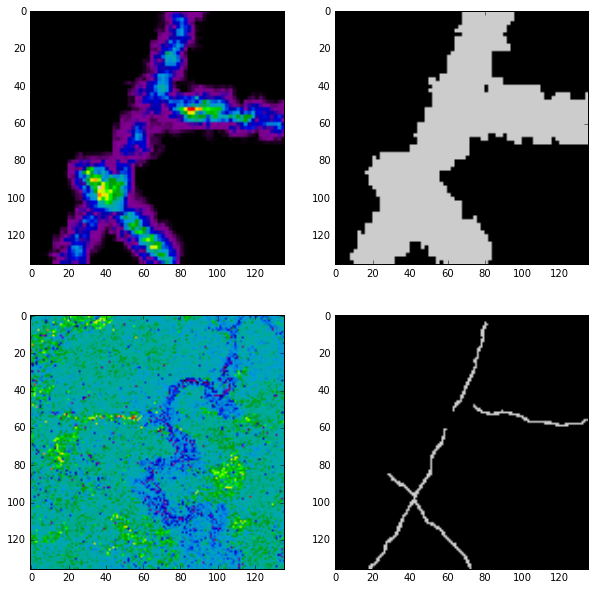

In [314]:
plot_all(3,classType)

### Predict off train data and plot images

In [241]:
training_outcomes = model.predict(y,batch_size=batch_size)

In [301]:
training_outcomes.shape

(25, 1, 136, 136)

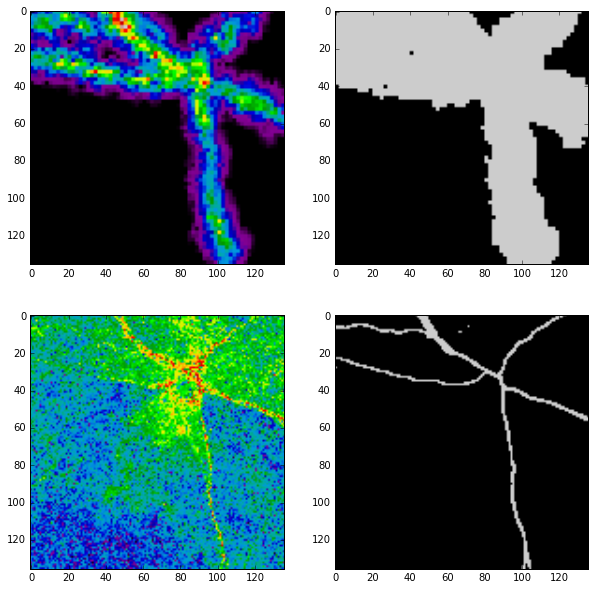

In [312]:
def plot_all(i,classType):
    fig = plt.figure(figsize=(10,10))

    ax1 = fig.add_subplot(221)
    ax1.imshow(training_outcomes[i,0,:,:],cmap='spectral')

    ax2 = fig.add_subplot(222)
    ax2.imshow(training_outcomes[i,0,:,:]>np.median(training_outcomes[5,0,:,:]),cmap='spectral')

    ax3 = fig.add_subplot(223)
    ax3.imshow(x[i,16,:,:],cmap='spectral')

    ax4 = fig.add_subplot(224)
    ax4.imshow(y[i,classType,:,:],cmap='spectral')
plot_all(5,classType)
#push('PICTURES!','The plots are ready')

In [449]:
# Load the testing data
# This is used for generating a submission
with open('./data/submission_resized_array.pickle','rb') as f:
    test_data = pickle.load(f)

In [450]:
# Split the testing data into values and keys
# It's currently a dict
test_values = np.array(list(test_data.values()))
test_ids = np.array(list(test_data.keys()))

In [ ]:
# Predict the rasters for the testing data
# Save the prediction results immediately so if something happens I don't ahve to train the model again

predictions = model.predict(test_values)
with open('./data/predictions.pickle','wb') as f:
    pickle.dump(predictions,f,pickle.HIGHEST_PROTOCOL)

In [115]:
# Load the predictions from file
with open('./data/predictions.pickle','rb') as f:
    predictions = pickle.load(f)

In [372]:
# Load all the various train_wkt files from kaggle...

train_wkt = pd.read_csv('./data/train_wkt_v2.csv',names=['imageID','feature','wkt'],skiprows=1)
train_wkt_old = pd.read_csv('./data/train_wkt.csv',names=['imageID','feature','wkt'],skiprows=1)
train_wkt_v3 = pd.read_csv('./data/train_wkt_v3.csv',names=['imageID','feature','wkt'],skiprows=1)

grid_sizes = pd.read_csv('./data/grid_sizes.csv',names=['imageID','xmax','ymin'],skiprows=1)

In [387]:
def polygonize_data():
    def polygonize(raster,feature,imageID):
        width_height_prime = 136*(136/(136+1))
        mask = raster != 0
        shape = cascaded_union([asShape(g) for g,_ in features.shapes(raster,mask=mask)])
        xmax = grid_sizes.loc[grid_sizes.imageID==imageID].xmax.values[0]
        ymin = grid_sizes.loc[grid_sizes.imageID==imageID].ymin.values[0]
        #print(feature,imageID)
        return [imageID,feature+1,scale(shape,xfact=xmax/width_height_prime, yfact=ymin/width_height_prime,origin=(0,0)).wkt]
    
    polygons = [polygonize(raster[feature,:,:].astype('float32'),feature,test_ids[n]) for n,raster in enumerate([predictions[n,:,:,:] for n in range(predictions.shape[0])]) for feature in range(10)]

    return polygons

In [ ]:
# Call the polygonize_data() function to generate the polygons from the predictions

submission_shapes = pd.DataFrame(polygonize_data(),columns=['ImageId','ClassType','MultipolygonWKT'])

In [ ]:
# Remove the imageIDs not found in train_wkt_old

submission_shapes = submission_shapes[~submission_shapes.ImageId.isin(train_wkt_old.imageID.unique())]

In [ ]:
# Convert column MultipolygonWKT to string

submission_shapes['MultipolygonWKT'] = submission_shapes['MultipolygonWKT'].astype(str)

In [ ]:
# Replace text for empty polygons with that required in the submission guidelines

submission_shapes.replace(to_replace='GEOMETRYCOLLECTION EMPTY', value='MULTIPOLYGON EMPTY',inplace=True)

In [ ]:
submission_shapes.shape

In [ ]:
# Save the submission file in compressed format

submission_shapes.to_csv('./data/submission.gz',index=False,compression='gzip')